In [1]:
import os
import zipfile
import shutil
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, Xception
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Path to the uploaded .zip file
zip_file_path = '/content/drive/MyDrive/severity_data.zip'

# Directory where you want to extract the files
extract_dir = '/content/severity_dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")


Extraction complete!


In [3]:
# Path to the uploaded .zip file
zip_file_path = '/content/drive/MyDrive/data.zip'

# Directory where you want to extract the files
extract_dir = '/content/data_set'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")


Extraction complete!


In [5]:
# Function to train model for each disease using MobileNet
def train_model_for_disease(disease_folder):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.15)

    train_generator = datagen.flow_from_directory(
        os.path.join('/content/severity_dataset/severity_data', disease_folder),
        target_size=(224,224),
        batch_size=5,
        class_mode='binary',  # Adjust for binary classification mild/severe
        subset='training')

    validation_generator = datagen.flow_from_directory(
        os.path.join('/content/severity_dataset/severity_data', disease_folder),
        target_size=(224,224),
        batch_size=5,
        class_mode='binary',  # Adjust for binary classification mild/severe
        subset='validation')

    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    steps_per_epoch = max(train_generator.samples // train_generator.batch_size, 1)
    validation_steps = max(validation_generator.samples // validation_generator.batch_size, 1)


    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        epochs=30,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )

    return model

In [6]:
# Train models for each disease
disease_models = {}
disease_folders = os.listdir('/content/severity_dataset/severity_data')
for disease_folder in disease_folders:
    if disease_folder.startswith('.'):
        continue
    print(f"Training model for {disease_folder}...")
    model = train_model_for_disease(disease_folder)
    disease_models[disease_folder] = model


Training model for narrow_brown_spot...
Found 42 images belonging to 2 classes.
Found 6 images belonging to 2 classes.
17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/30
8/8 [==============================] - 9s 371ms/step - loss: 0.6198 - accuracy: 0.6216 - val_loss: 0.4022 - val_accuracy: 0.6000
Epoch 2/30
8/8 [==============================] - 1s 123ms/step - loss: 0.3992 - accuracy: 0.7568 - val_loss: 0.2545 - val_accuracy: 0.8000
Epoch 3/30
8/8 [==============================] - 1s 109ms/step - loss: 0.4186 - accuracy: 0.7568 - val_loss: 0.2567 - val_accuracy: 0.8000
Epoch 4/30
8/8 [==============================] - 1s 117ms/step - loss: 0.2602 - accuracy: 0.9189 - val_loss: 0.4608 - val_accuracy: 0.8000
Epoch 5/30
8/8 [==============================] - 1s 132ms/step - loss: 0.2026 - accuracy: 0.8919 - val_loss: 0.4224 - val_accuracy: 0.6000
Epoch 6/30
8/8 [==============================] - 1s 139ms/step - loss: 0.2341 - accuracy: 0.9189 - val_loss: 0.1161

In [7]:
# Function to predict severity using appropriate model
def predict_severity_for_image(img_path, disease_model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = disease_model.predict(img_array)
    return 'mild' if prediction < 0.5 else 'severe'

# Paths
larger_dataset_dir = '/content/data_set/data'
annotated_dataset_dir = '/content/annotated_dataset'

# Create annotated dataset directories
for disease_folder in disease_folders:
    if disease_folder == 'healthy':
        # Skip annotation for healthy images
        continue
    for severity_folder in ['mild', 'severe']:
        os.makedirs(os.path.join(annotated_dataset_dir, disease_folder+ '_' +  severity_folder), exist_ok=True)

# Annotate and move images
for disease_folder in os.listdir(larger_dataset_dir):
    if disease_folder == 'healthy':
        # Skip annotation for healthy images
        continue

    for img_name in os.listdir(os.path.join(larger_dataset_dir, disease_folder)):
        img_path = os.path.join(larger_dataset_dir, disease_folder, img_name)
        disease_model = disease_models[disease_folder]
        predicted_severity = predict_severity_for_image(img_path, disease_model)
        dest_path = os.path.join(annotated_dataset_dir, disease_folder + '_' + predicted_severity, img_name)
        shutil.copy(img_path, dest_path)


1/1 [==============================] - 0s 19ms/step


In [8]:
# Paths
annotated_dataset_dir = '/content/annotated_dataset'
class_folders = [folder_name for folder_name in os.listdir(annotated_dataset_dir) if not folder_name.startswith('.') and os.path.isdir(os.path.join(annotated_dataset_dir, folder_name))]

In [9]:
print(len(class_folders))

18


In [10]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15)

train_generator = datagen.flow_from_directory(
    annotated_dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=class_folders)

validation_generator = datagen.flow_from_directory(
    annotated_dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes = class_folders)


Found 3067 images belonging to 18 classes.
Found 533 images belonging to 18 classes.


In [11]:
# Early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Function to create a CNN model
# def create_cnn_model():
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(18, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model


In [12]:
# Function to create a transfer learning model
def create_transfer_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(18, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
#  Create and train models
# cnn_model = create_cnn_model()
# cnn_history = cnn_model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=validation_generator,
#     callbacks=[early_stopping]
# )

In [14]:

# vgg16_model = create_transfer_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# vgg16_history = vgg16_model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=validation_generator,
#     callbacks=[early_stopping]
# )


In [15]:

'''resnet50_model = create_transfer_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
resnet50_history = resnet50_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)'''


"resnet50_model = create_transfer_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))\nresnet50_history = resnet50_model.fit(\n    train_generator,\n    epochs=10,\n    validation_data=validation_generator,\n    callbacks=[early_stopping]\n)"

In [16]:
inceptionv3_model = create_transfer_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
inceptionv3_history = inceptionv3_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/10
96/96 [==============================] - 108s 1s/step - loss: 2.3599 - accuracy: 0.2784 - val_loss: 1.5770 - val_accuracy: 0.5553
Epoch 2/10
96/96 [==============================] - 94s 976ms/step - loss: 1.7240 - accuracy: 0.4591 - val_loss: 1.1788 - val_accuracy: 0.6773
Epoch 3/10
96/96 [==============================] - 93s 968ms/step - loss: 1.4839 - accuracy: 0.5321 - val_loss: 1.0630 - val_accuracy: 0.6848
Epoch 4/10
96/96 [==============================] - 94s 982ms/step - loss: 1.3978 - accuracy: 0.5553 - val_loss: 0.9493 - val_accuracy: 0.6998
Epoch 5/10
96/96 [==============================] - 95s 995ms/step - loss: 1.2856 - accuracy: 0.5778 - val_loss: 0.9199 - val_accuracy: 0.7242
Epoch 6/10
96/96 [==============================] - 98s 1s/step - loss: 1.2355 - accuracy: 0.6012 - val_loss: 0.8778 - val_accuracy: 0.7186
Epoch 7/10
96/96 [==============================] - 96s 1s/step - loss: 1.2037 - a

In [17]:

xception_model = create_transfer_model(Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
xception_history = xception_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


83683744/83683744 [==============================] - 3s 0us/step
Epoch 1/10
96/96 [==============================] - 106s 1s/step - loss: 2.0207 - accuracy: 0.3981 - val_loss: 1.3237 - val_accuracy: 0.5985
Epoch 2/10
96/96 [==============================] - 94s 979ms/step - loss: 1.3442 - accuracy: 0.5813 - val_loss: 1.0851 - val_accuracy: 0.6698
Epoch 3/10
96/96 [==============================] - 98s 1s/step - loss: 1.1340 - accuracy: 0.6397 - val_loss: 0.9152 - val_accuracy: 0.7167
Epoch 4/10
96/96 [==============================] - 95s 995ms/step - loss: 1.0599 - accuracy: 0.6651 - val_loss: 0.8498 - val_accuracy: 0.7486
Epoch 5/10
96/96 [==============================] - 95s 989ms/step - loss: 0.9893 - accuracy: 0.6792 - val_loss: 0.7998 - val_accuracy: 0.7505
Epoch 6/10
96/96 [==============================] - 93s 975ms/step - loss: 0.8893 - accuracy: 0.7121 - val_loss: 0.7602 - val_accuracy: 0.7486
Epoch 7/10
96/96 [==============================] - 96s 1s/step - loss: 0.8657 - a

In [18]:
# Evaluate models
def evaluate_model(model):
    val_loss, val_accuracy = model.evaluate(validation_generator)
    return val_accuracy
#cnn_accuracy = evaluate_model(cnn_model)
#vgg16_accuracy = evaluate_model(vgg16_model)
inceptionv3_accuracy = evaluate_model(inceptionv3_model)
xception_accuracy = evaluate_model(xception_model)


17/17 [==============================] - 14s 848ms/step - loss: 0.6512 - accuracy: 0.7786


In [19]:
#'VGG16': vgg16_accuracy,
# 'CNN': cnn_accuracy,
accuracies = {


    'InceptionV3': inceptionv3_accuracy,
    'Xception': xception_accuracy
}

best_model_name = max(accuracies, key=accuracies.get)
best_model_accuracy = accuracies[best_model_name]

print(f"Best model: {best_model_name} with accuracy: {best_model_accuracy}")

Best model: Xception with accuracy: 0.7786116600036621


In [20]:
best_model = None
if best_model_name == 'InceptionV3':
    best_model = inceptionv3_model
elif best_model_name == 'Xception':
    best_model = xception_model
'''
if best_model_name == 'CNN':
    best_model = cnn_model
elif best_model_name == 'VGG16':
    best_model = vgg16_model
el
'''

"\nif best_model_name == 'CNN':\n    best_model = cnn_model\nelif best_model_name == 'VGG16':\n    best_model = vgg16_model\nel\n"

In [21]:
# Create ensemble predictions (average method)
def ensemble_predict(image_path, models):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = [model.predict(img_array) for model in models]
    avg_prediction = np.mean(predictions, axis=0)
    return np.argmax(avg_prediction)
#models = [cnn_model, vgg16_model, resnet50_model, inceptionv3_model, xception_model]
# Example usage for ensemble prediction
image_path = '/content/data_set/data/brown_spot/brown_spot0.jpg'
models = [inceptionv3_model, xception_model]
ensemble_prediction = ensemble_predict(image_path, models)
print(f"Ensemble model prediction: {ensemble_prediction}")


1/1 [==============================] - 1s 1s/step
Ensemble model prediction: 3


In [22]:
# Load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

# Test the best model with an image
test_image_path = '/content/data_set/data/brown_spot/brown_spot0.jpg'
img_array = load_and_preprocess_image(test_image_path)
prediction = best_model.predict(img_array)
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
predicted_class = class_labels[np.argmax(prediction)]
print(f'Test Image: {test_image_path}, Predicted Class: {predicted_class}')


1/1 [==============================] - 0s 22ms/step
Test Image: /content/data_set/data/brown_spot/brown_spot0.jpg, Predicted Class: brown_spot_mild


In [29]:
print(class_labels)

{0: 'leaf_scald_severe', 1: 'bacterial_leaf_blight_severe', 2: 'leaf_scald_mild', 3: 'brown_spot_mild', 4: 'sheath_blight_mild', 5: 'leaf_blast_severe', 6: 'neck_blast_severe', 7: 'narrow_brown_spot_mild', 8: 'neck_blast_mild', 9: 'rice_hispa_mild', 10: 'tungro_mild', 11: 'rice_hispa_severe', 12: 'brown_spot_severe', 13: 'leaf_blast_mild', 14: 'tungro_severe', 15: 'sheath_blight_severe', 16: 'bacterial_leaf_blight_mild', 17: 'narrow_brown_spot_severe'}


In [23]:
# Compute ensemble accuracy on validation set
correct_predictions = 0
total_predictions = 0

for i in range(len(validation_generator)):
    x, y_true = validation_generator[i]
    for j in range(len(x)):
        img = x[j]
        true_label = np.argmax(y_true[j])
        img_path = "/content/data_set/data/brown_spot/brown_spot0.jpg"
        image.save_img(img_path, img)
        predicted_label = ensemble_predict(img_path, [inceptionv3_model, xception_model])

        if predicted_label == true_label:
            correct_predictions += 1
        total_predictions += 1

ensemble_accuracy = correct_predictions / total_predictions
print(f"Ensemble model accuracy: {ensemble_accuracy}")


1/1 [==============================] - 0s 20ms/step
Ensemble model accuracy: 0.7711069418386491


In [24]:
if ensemble_accuracy > best_model_accuracy:
    # Save the ensemble model components
    #vgg16_model.save('vgg16_model.h5')
    inceptionv3_model.save('inceptionv3_model.h5')
    xception_model.save('xception_model.h5')
    print("Ensemble model components saved as vgg16_model.h5, inceptionv3_model.h5, xception_model.h5")
else:
    # Save the best individual model
    best_model.save('best_model.h5')
    print("Best model saved as best_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Best model saved as best_model.h5


In [25]:
if best_model_name == 'InceptionV3':
    best_model_history = inceptionv3_history
elif best_model_name == 'Xception':
    best_model_history = xception_history

# if best_model_name == 'CNN':
#     best_model_history = cnn_history
# elif best_model_name == 'VGG16':
#     best_model_history = vgg16_history


In [26]:
import matplotlib.pyplot as plt

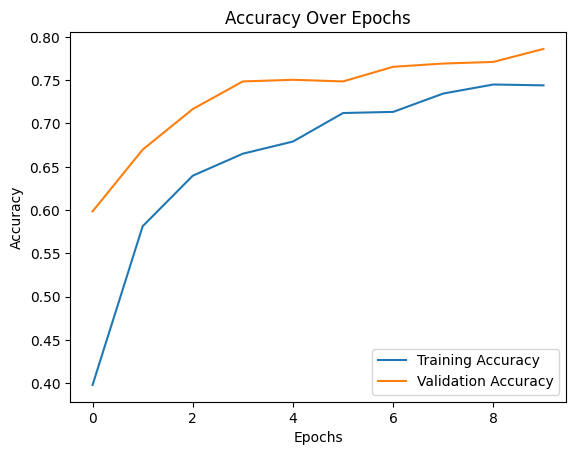

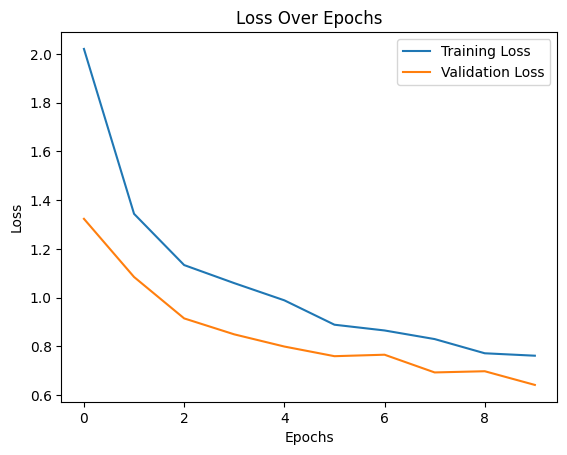

In [27]:
plt.plot(best_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# Plotting the loss
plt.plot(best_model_history.history['loss'], label='Training Loss')
plt.plot(best_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [28]:
import shutil

def zip_folder(folder_path, output_path):
    """
    Zips the contents of a folder.

    Parameters:
    folder_path (str): Path to the folder to be zipped.
    output_path (str): Path for the output zipped file.
    """
    shutil.make_archive(output_path, 'zip', folder_path)

# Example usage
folder_to_zip = '/content/annotated_dataset'  # replace with your folder name
output_zip_path = '/content/annotated_dataset_zip_folder'  # replace with your desired output zip file name

zip_folder(folder_to_zip, output_zip_path)